In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [204]:
columns = ['Order_date', 'Order_ID', 'Purchased_product_ID', 'Quantity_of_SKU_in_the_order', 'Category_ID', 'Category_alias', 'Brand_ID', 'Price', 'User_ID', 'Product_gender', 'Colour', 'Metal', 'Gem']

In [205]:
df = pd.read_csv('jewelry.csv', names=columns)

In [206]:
df.head(4)

,Order_date,Order_ID,Purchased_product_ID,Quantity_of_SKU_in_the_order,Category_ID,Category_alias,Brand_ID,Price,User_ID,Product_gender,Colour,Metal,Gem
0,2018-12-01 11:40:29 UTC,1924719191579951782,1842195256808833386,1,1.806829e+18,jewelry.earring,0.0,561.51,1.515916e+18,NaN,red,gold,diamond
1,2018-12-01 17:38:31 UTC,1924899396621697920,1806829193678291446,1,1.806829e+18,NaN,NaN,212.14,1.515916e+18,NaN,yellow,gold,NaN
2,2018-12-02 13:53:42 UTC,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire
3,2018-12-02 17:44:02 UTC,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond


In [207]:
df.dtypes

Order_date                       object
Order_ID                          int64
Purchased_product_ID              int64
Quantity_of_SKU_in_the_order      int64
Category_ID                     float64
Category_alias                   object
Brand_ID                        float64
Price                           float64
User_ID                         float64
Product_gender                   object
Colour                           object
Metal                            object
Gem                              object
dtype: object

In [208]:
df['Order_date'] = df['Order_date'].apply(lambda x: x.replace(' UTC', ''))

In [209]:
df['Order_date'] = df['Order_date'].apply(pd.to_datetime)

### Сколько у каждого покупателя в среднем покупок в месяц?

In [334]:
orders_by_month = df.groupby(['User_ID', df['Order_date'].dt.to_period('M')]).agg({'Order_ID':'count'})
orders_by_month = orders_by_month.groupby('User_ID').agg({'Order_ID':'mean'}).rename(columns={'Order_ID':'AVG_orders'}).reset_index()

In [336]:
orders_by_month.head()

,User_ID,AVG_orders
0,1.313554e+18,1.000000
1,1.313556e+18,2.000000
2,1.313566e+18,1.666667
3,1.313582e+18,1.000000
4,1.313591e+18,1.600000


 ### Когда (месяц и год) было самое большое количество покупок? На какую сумму?

In [343]:
max_orders = df.groupby(df['Order_date'].dt.to_period('M')).agg({'Order_ID':'count', 'Price':'sum'}) \
.rename(columns={'Order_ID':'Orders', 'Price':'Revenue'}).sort_values('Orders', ascending=False)
max_orders.head(1)

,Orders,Revenue
Order_date,,
2021-11,8673,3674627.42


### В какой день недели каждый товар чаще всего покупается?

In [309]:
df['Day_of_week'] = df['Order_date'].dt.day_name()
products_by_days = df.groupby(['Purchased_product_ID', 'Day_of_week'], as_index=False).agg({'Order_ID':'count'})
products_by_days = products_by_days.pivot(index='Purchased_product_ID', columns='Day_of_week', values='Order_ID')

In [324]:
is_max = products_by_days.eq(products_by_days.max(axis=1), axis=0)
result = is_max.dot(products_by_days.columns + ' ')
max_days = pd.DataFrame(result).rename({0:'Day_of_week'}, axis=1).reset_index()
max_days['Day_of_week'] = max_days['Day_of_week'].apply(lambda x: x.split(' ')[:-1])
max_days = max_days.explode('Day_of_week')

In [325]:
max_days.head()

,Purchased_product_ID,Day_of_week
0,1313550904313512734,Monday
1,1313551664447226717,Friday
1,1313551664447226717,Thursday
2,1313552505925272466,Friday
3,1313552709323850660,Thursday


<AxesSubplot:xlabel='Day_of_week', ylabel='count'>

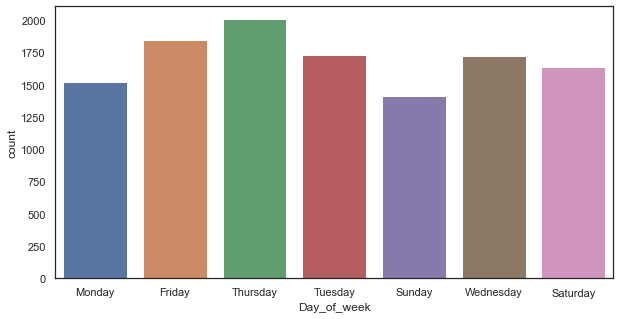

In [326]:
plt.figure(figsize=(10, 5))
sns.set_theme(style="white")
sns.countplot(x="Day_of_week", data=max_days)

### Cohort analysis

In [210]:
first_order = df.groupby('User_ID', as_index=False).agg({'Order_date':'min'}).rename(columns={'Order_date':'First_order'})

In [211]:
df = df.merge(first_order, on='User_ID')

In [212]:
df['Date_diff'] = (df['Order_date'] - df['First_order']).dt.days

In [213]:
df['Cohort_period'] = pd.cut(df['Date_diff'], [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 100000], 
                             labels=['0 day', '30 d', '60 d', '90 d', '120 d', '150 d', '180 d', '210 d', '240 d', '270 d', '300 d', '330 d', '360 d', '>360 d'])

In [214]:
cohort_0 = df.query("Cohort_period=='0 day'").groupby(df['First_order'].dt.to_period('M')).agg({'User_ID':'nunique'})['User_ID']

In [215]:
cohort_0

First_order
2018-12      66
2019-01     188
2019-02     212
2019-03     206
2019-04     153
2019-05     152
2019-06     138
2019-07     215
2019-08     203
2019-09     150
2019-10     281
2019-11     330
2019-12     440
2020-01     337
2020-02     318
2020-03     359
2020-04     269
2020-05     231
2020-06     259
2020-07     309
2020-08     459
2020-09     508
2020-10     523
2020-11     717
2020-12    3569
2021-01    1667
2021-02    1717
2021-03    2135
2021-04    1453
2021-05    1425
2021-06    1399
2021-07    1618
2021-08    2214
2021-09    1564
2021-10    1490
2021-11    3737
2021-12      68
Freq: M, Name: User_ID, dtype: int64

In [216]:
cohorts = df.groupby([df['First_order'].dt.to_period('M'), 'Cohort_period']).agg({'User_ID':'nunique'}).reset_index()

In [217]:
cohorts = cohorts.pivot(index=['First_order'], columns=['Cohort_period'], values=['User_ID'])

In [218]:
cohorts = cohorts.divide(cohort_0, axis=0)

In [219]:
cohorts = (cohorts
            .style
            .set_caption('Customer retention by cohort')
            .background_gradient(cmap='viridis') 
            .highlight_null('white') 
            .format("{:.2%}", na_rep="")) 
cohorts

### RFM analysis
__R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.__

In [269]:
last_date = df['Order_date'].max()

In [270]:
df['Days_since_order'] = (last_date - df['Order_date']).dt.days

In [271]:
rfm_df = df.groupby('User_ID', as_index=False).agg({
                                     'Order_date': lambda x: (last_date - x.max()).days,
                                     'Order_ID': lambda x: len(x),
                                     'Price': lambda x: x.sum()})

In [272]:
rfm_df.rename(columns={'Order_date':'Recency', 'Order_ID':'Frequency', 'Price':'Monetary'}, inplace=True)

In [296]:
quintiles = rfm_df[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 64.0, 0.4: 166.0, 0.6: 276.0, 0.8: 352.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 2.0},
 'Monetary': {0.2: 142.196, 0.4: 260.0, 0.6: 431.37, 0.8: 868.3740000000003}}

In [297]:
rfm_df['R'] = pd.qcut(rfm_df['Recency'], 5, labels=[1, 2, 3, 4, 5])

In [298]:
rfm_df['F'] = pd.cut(rfm_df['Frequency'], 5, labels=[5, 4, 3, 2, 1])

In [299]:
rfm_df['M'] = pd.qcut(rfm_df['Monetary'], 5, labels=[5, 4, 3, 2, 1])

In [302]:
rfm_df['RFM'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)

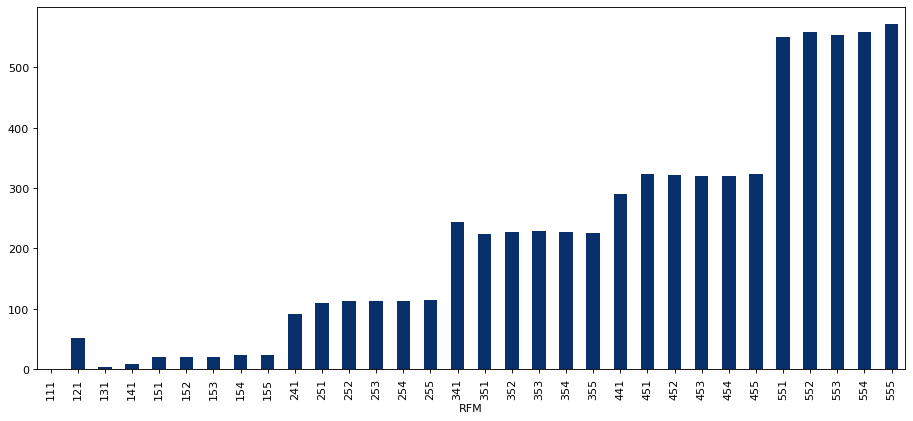

In [306]:
fig=plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
rfm_df.groupby('RFM').agg('Recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()